In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

In [3]:
# For additional statistical analysis
import pingouin as pg
from pingouin import pairwise_ttests

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# declare a Base using 'automap_base()'
Base = automap_base()

In [7]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.

period_start = dt.date(2017,8,23) - dt.timedelta(days=365)
period_start

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores

last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= period_start).all()

last_year_data[0:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(last_year_data, columns = ['Date', 'Precipitation'])
prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [15]:
# Sort the dataframe by date and set index as 'Date'
prcp_df = prcp_df.sort_values(by=['Date']).set_index(['Date'])
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


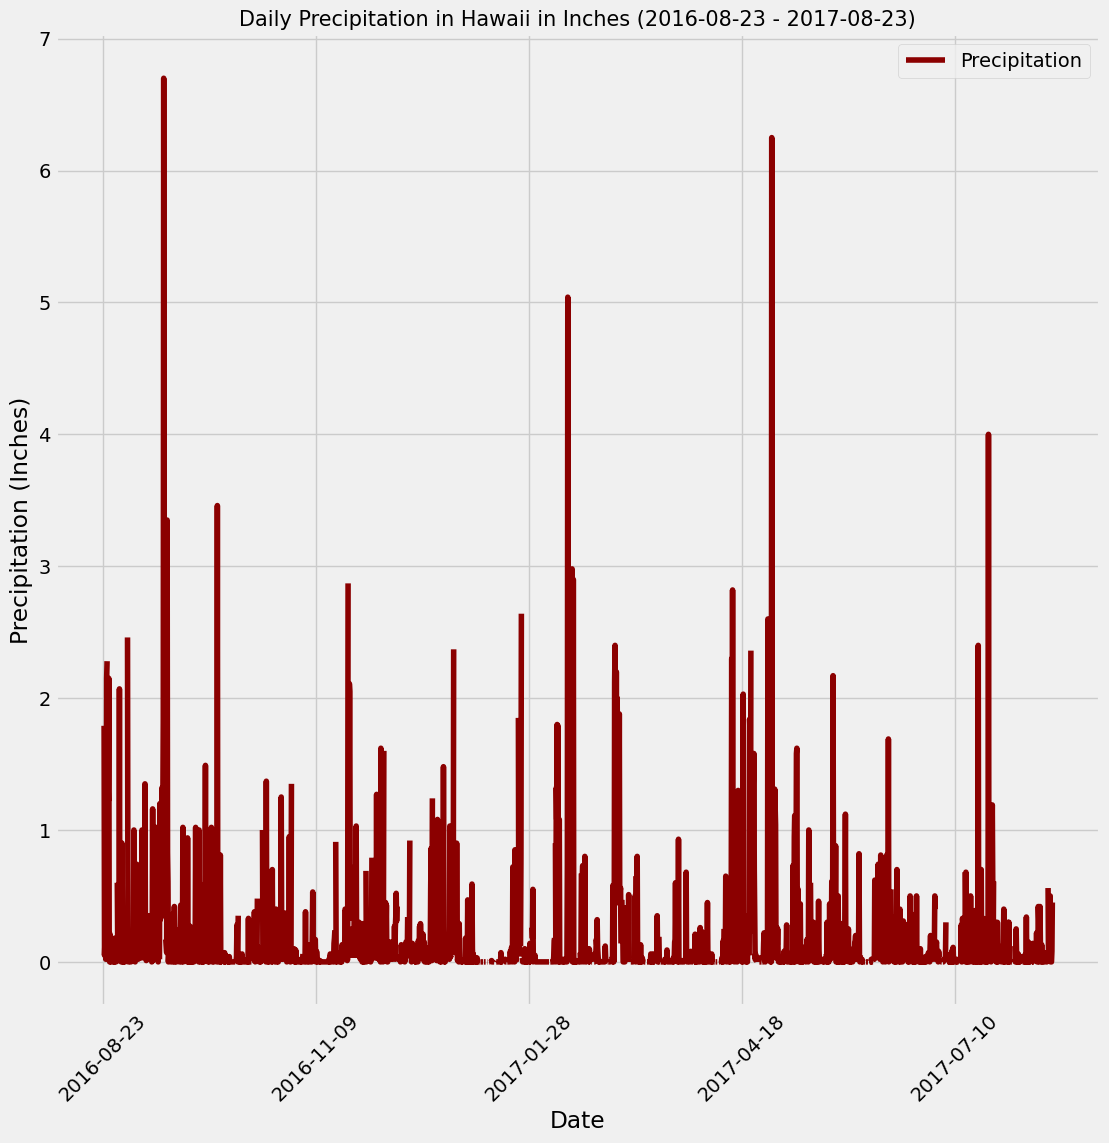

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(color = 'darkred', rot=45, figsize=[12,12])

plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title(f"Daily Precipitation in Hawaii in Inches ({period_start} - {most_recent_date})", size=15)
plt.savefig("Results/precipitation_plot.png")
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.Precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

### Zoom out to weekly level of analysis

In [18]:
# Resample weekly for mean
# Note: Resampling requires input as index
df = prcp_df.copy()
df.index = pd.to_datetime(df.index)
mean_df = df.resample('w').mean()
mean_df.head()

,Precipitation
Date,
2016-08-28,0.447222
2016-09-04,0.206486
2016-09-11,0.209459
2016-09-18,0.638000
2016-09-25,0.134091


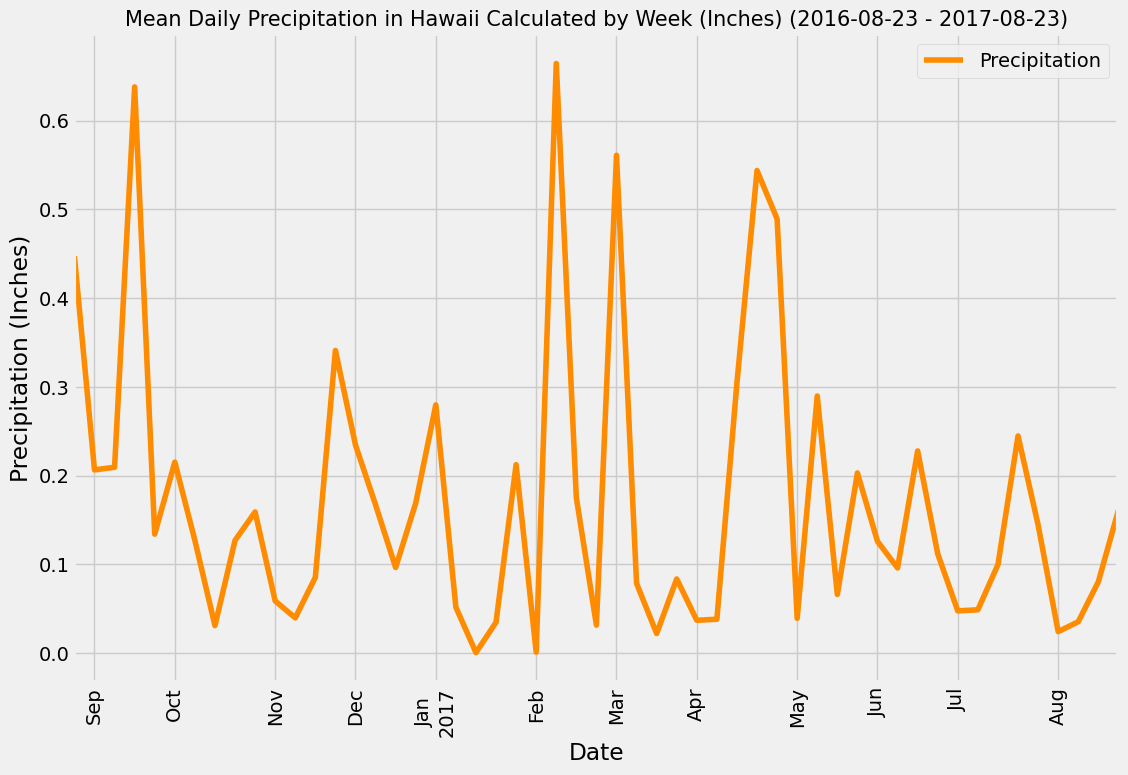

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
mean_df.plot(color = 'darkorange', rot=90, figsize=[12,8])

plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title(f"Mean Daily Precipitation in Hawaii Calculated by Week (Inches) ({period_start} - {most_recent_date})", size=15)
plt.savefig("Results/mean_daily_precipitation_plot.png")
plt.show()

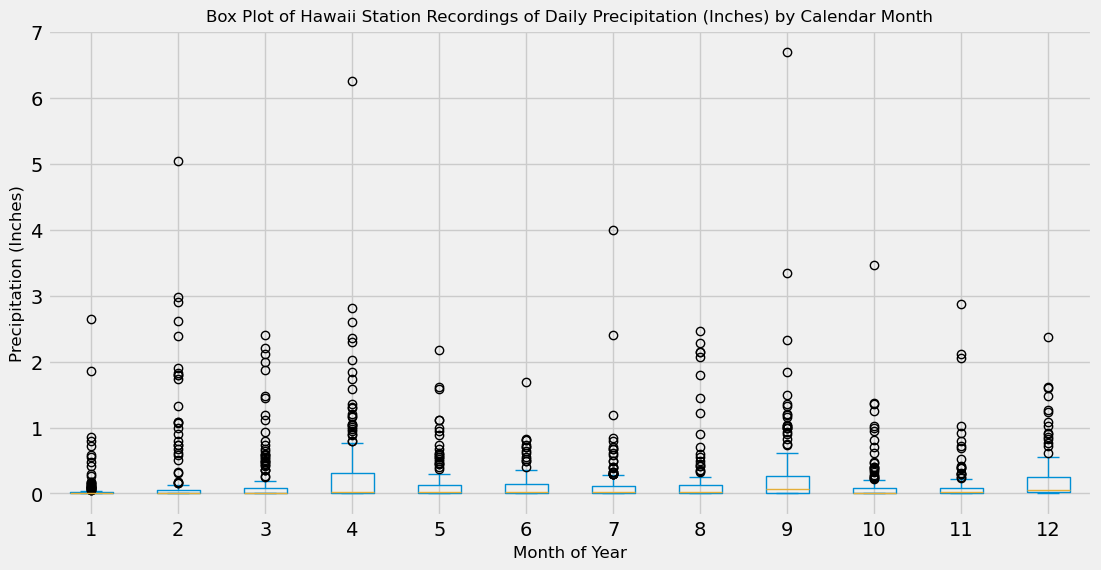

In [20]:
# Use datetime and a lambda function to extract month from 'Date'
month_ts = df.reset_index()
month_ts["Month"] = month_ts.Date.map(lambda x: x.month)
month_ts.plot.box(by="Month", figsize=[12,6])

plt.xlabel("Month of Year", size=12)
plt.ylabel("Precipitation (Inches)", size=12)
plt.title("Box Plot of Hawaii Station Recordings of Daily Precipitation (Inches) by Calendar Month", size=12)
plt.savefig("Results/monthly_precipitation_boxplot.png")
plt.show()

In [21]:
month_ts.columns

Index(['Date', 'Precipitation', 'Month'], dtype='object')

In [22]:
# Use pingouin to perform pairwise ttests on monthly mean precipitation
pairwise = pg.pairwise_gameshowell(data=month_ts, dv='Precipitation', between='Month').sort_values(['pval'], ascending = True).set_index('A')
significant_pairwise = pairwise[pairwise.pval <= .05]
significant_pairwise

,B,mean(A),mean(B),diff,se,T,df,pval,hedges
A,,,,,,,,,
1,4,0.070294,0.321111,-0.250817,0.057741,-4.343848,221.537336,0.001262,-0.468415
1,9,0.070294,0.285549,-0.215255,0.054618,-3.941128,230.862049,0.005932,-0.422067
1,12,0.070294,0.199494,-0.129200,0.033303,-3.879578,336.436991,0.006927,-0.413101
4,6,0.321111,0.120000,0.201111,0.056240,3.575927,202.363565,0.021672,0.385874
4,11,0.321111,0.120234,0.200877,0.059771,3.360800,246.579628,0.041619,0.362660
4,10,0.321111,0.121620,0.199491,0.059582,3.348203,244.873800,0.043273,0.362304


In [23]:
# Write the ttest table to a csv file
significant_pairwise.to_csv("Results/pairwise_ttests_precipitation_by_month.csv")

### Discussion: In Hawaii, between 8/23/16 and 8/23/17, average daily precipitation in January was significantly different from that in April, September, and December. Furthermore, average daily precipitation in April was significantly different from that in June, November, and December. Specifically, days in January were significantly "drier" than its pairwise counterparts and days in April were significantly "wetter" than its counterparts.

# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
n_stations = session.query(Station.station).count()
n_stations

9

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
station_activity[0:5]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0]
most_active_station

'USC00519281'

In [27]:
most_active_station_temperatures = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station)
most_active_station_temperatures

In [28]:
most_active_temp_df = pd.DataFrame(most_active_station_temperatures, columns = ['Station', 'Temperature'])
most_active_temp_df.head()

,Station,Temperature
0,USC00519281,70.0
1,USC00519281,62.0
2,USC00519281,74.0
3,USC00519281,75.0
4,USC00519281,74.0


In [29]:
most_active_temp_df.Temperature.describe()

count    2772.000000
mean       71.663781
std         4.357642
min        54.000000
25%        69.000000
50%        72.000000
75%        74.000000
max        85.000000
Name: Temperature, dtype: float64

In [30]:
lowest_temp = most_active_temp_df.Temperature.min()
highest_temp = most_active_temp_df.Temperature.max()
average_temp = most_active_temp_df.Temperature.mean()

print(lowest_temp, highest_temp, average_temp)

54.0 85.0 71.66378066378067


In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
MAS_year_query = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= period_start).all()

MAS_annual_temp_df = pd.DataFrame(MAS_year_query, columns = ['Station', 'Temperature'])
MAS_annual_temp_df

,Station,Temperature
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0
...,...,...
347,USC00519281,77.0
348,USC00519281,77.0
349,USC00519281,76.0
350,USC00519281,76.0


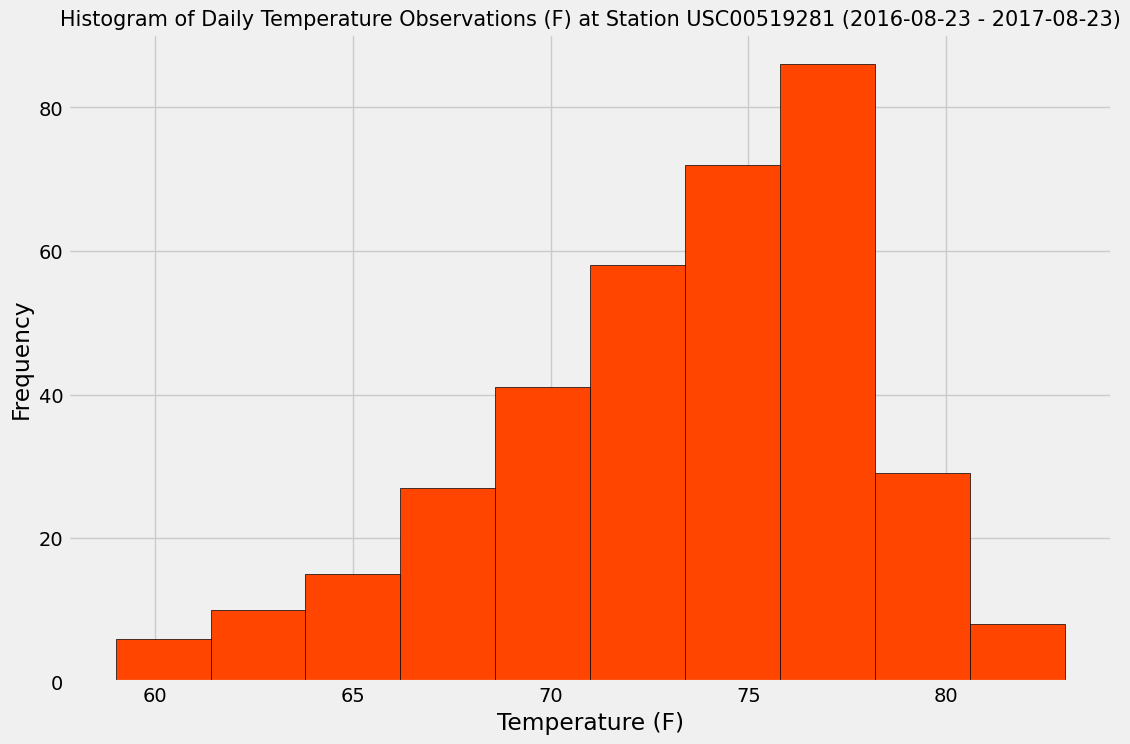

In [35]:
MAS_annual_temp_df.Temperature.plot.hist(figsize = [12,8], color = 'orangered', edgecolor = 'black')

plt.title(f"Histogram of Daily Temperature Observations (F) at Station {most_active_station} ({period_start} - {most_recent_date})", size = 15)
          
plt.xlabel("Temperature (F)")
plt.savefig("Results/temperature_histogram.png")
plt.show()

# Close Session

In [33]:
# Close Session
session.close()